# Introduction and Abstract
* There are many black box detectors which are mostly based on Machine Learning. As a matter of fact, they have improved the security against malware attacks reasonably. But are they perfect?
* This work shows that the black box anti-virus softwares are not reliable and can be broken down by using the same Machine Learning techniques.
* This methodology involves training a General Adversial Network to produce malware samples that convinces the Black Box Detectors that they are benign.
* There are some similar works done in this area, and this work is an extension of them. But most importantly, this method is used to produce malware samples that could be injected into android apps, and make them appear benign. As most of the malware is now being shared and replicated through apps, this is consdered to be severely important.

# Related Work
* https://arxiv.org/abs/1702.05983
* https://ieeexplore.ieee.org/abstract/document/8424635

In [1]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf

# Dataset and Features

* The dataset is owned by Google which is used to detect malware and benign samples, given a set of apps and its features like permissions taken and API calls.
* The data is in the form of one hot vectors with different permissions and API calls. This is well suited for generation by GAN's because of several conceptual and engineering challenges.
* There are many works that make GAN produce tabular numeric data, but there is no proper standard and guarantee that they work all the time. Fortunately, most of the black box detectors deal with the data containing mostly categorical or just binary data.
* Such output distribution can be modeled well by GAN's for bypassing the BBD's.

In [2]:
raw_mal = pd.read_csv('../input/ml-final-dataset/Malware_Data.csv')
raw_benign = pd.read_csv('../input/ml-final-dataset/PlayStore Application.csv')

## Removing missing values

In [3]:
l = raw_benign.isnull().sum()
rem_col = []
for i,col in enumerate(raw_benign.columns):
    if l[i]>1000:
        rem_col.append(col)
raw_benign = raw_benign.drop(rem_col,axis=1)
raw_mal = raw_mal.drop(rem_col,axis=1)

## Selecting the number of features

In [4]:
no_features=350
no_samples = 10000

In [5]:
fin_mal = raw_mal.iloc[:,2:no_features+2]
fin_benign = raw_benign.iloc[:20000,2:no_features+2]
mal_labels = np.ones((fin_mal.shape[0],1))
benign_labels = np.zeros((fin_benign.shape[0],1))

In [6]:
print(mal_labels.shape[0])
print(benign_labels.shape[0])


10000
10000


# Approach
* We first train a Black Box detector on our dataset, so that it can detect the malware and benign samples perfectly. This way, we mimic the actual BBD.
* Then we will have a naive GAN (Generator and Discriminator) that is trained to produce malware samples that appears to be benign.
* We observe the performance by noticing the True Positive Rate(TPR) which is defined as the rate at which the BBD correctly identifies the malware samples. So, lower the TPR, The better the performance of our model.

# Building the Black Box Detector

* The black-box detector is an external system which adopts machine learning based malware detection algorithms. We assume that the only thing malware authors know about the black-box detector is what kind of features it uses.
* Hence we model the black box detector and can know the performance by seeing how well we ae able to fool it.(lower TPR)

In [7]:
total_data = pd.concat([fin_mal,fin_benign],axis=0)
total_labels = pd.concat([pd.DataFrame(mal_labels),pd.DataFrame(benign_labels)],axis=0)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(total_data,total_labels,test_size=0.3)

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf.fit(total_data,total_labels)
clf.score(X_test,y_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.9688333333333333

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kf = KFold(n_splits=10)
score = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=0),total_data,total_labels)
print(score)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 

[0.96275 0.949   0.9165  0.913   0.8735 ]


In [23]:
fin_mal = np.array(fin_mal)
fin_benign = np.array(fin_benign)
fin_benign.shape, fin_mal.shape

((10000, 350), (10000, 350))

# Building the MalGAN
*  MalGAN uses a substitute detector to fit the black-box malware detection system. A generative network is trained to minimize the generated adversarial examples’ malicious probabilities predicted by the substitute detector.

In [12]:
    noise_dim = 128
    dense_dim = 1024
    batch_size = 64
    optimizer = tf.keras.optimizers.Adam(0.001)

## Building the Generator
* This generator generates new sample given the input of malware samples.
* The generator finally produces the correct configuration of API calls and permission to bypass the BBD, at the same time conserving the neccacities of the actual Malware.
* Stochastisity and diversity in generated samples is achieved by the random noise appended to the malware features.
* The generator is used to transform a malware feature vector into its adversarial version. It takes the concatenation of a malware feature vector m and a noise vector z as input.
* When generating adversarial examples for binary malware features we only consider to add some irrelevant features to malware. Removing a feature from the original malware maycrack it.

In [13]:
def generator():
    
    inp = tf.keras.layers.Input(shape=(no_features))
    noise = tf.keras.layers.Input(shape=(noise_dim))
    full_inp = tf.keras.layers.Concatenate(axis=1)([inp,noise])
    #d_a1 = tf.keras.layers.Dense(2048)(full_inp)
    d1 = tf.keras.layers.Dense(1024)(full_inp)
    fin = tf.keras.layers.Dense(no_features,activation='sigmoid')(d1)
    
    out = tf.keras.layers.Maximum()([inp,fin])
    
    model = tf.keras.Model([inp,noise],out)
    return model
    

## Building the discriminator
* The discriminator is the adversary of the generator which detects wheather a sample is malware or benign.
* It is the discriminator which guides the generator to produce convincing malware samples.
* Since malware authors know nothing about the detailed structure of the black-box detector, the substitute detector is used to fit the black-box detector and provides gradient information to train the generator.

In [14]:
def discriminator():
    
    inp = tf.keras.layers.Input(shape=(no_features))
    d2 = tf.keras.layers.Dense(1024)(inp)
    
    
    out = tf.keras.layers.Dense(1)(d2)
    
    model = tf.keras.Model(inp,out)
    return model

## MalGAN (Combining generator and disriminator)

* The training data of the substitute detector consist of adversarial malware examples from the generator, and benign programs from an additional benign dataset collected by malware authors. The ground-truth labels of the training data are not used to train the substitute detector. The goal of the substitute detector is to fit the black-box detector.
* . The generator and the substitute detector work together to attack a machine learning based black-box malware detector.

In [15]:
def gan_total(gen,disc):
    
    inp = tf.keras.layers.Input(shape=(no_features))
    noise = tf.keras.layers.Input(shape=(noise_dim))
    full_inp = tf.keras.layers.Concatenate(axis=1)([inp,noise])
    
    gen_mal = gen([inp,noise])
    disc.trainable = False
    
    disc_pred = disc(gen_mal)
    
    final_gan = tf.keras.Model([inp,noise],disc_pred)
    
    return final_gan

In [16]:
    gen = generator()
    disc = discriminator()
    disc.compile(optimizer=optimizer,loss='mse')
    gan = gan_total(gen,disc)
    gan.compile(optimizer=optimizer,loss='mse')

## Training the GAN
* The batch size is chosen carefully so that the discrminator does not become too powerful.
* The learning is set at different positions, 0.001, 0.0001, 0.0005, 0.005. The default 0.001 appears to work best.
* Loss functions like crossentropy ans mse are tested. MSE appears to be quite stable while training and for good TPR's.

In [17]:
    def train_step():
    
        idx = np.random.randint(0, fin_mal.shape[0], batch_size)
        mal_samples = fin_mal[idx]
        noise = np.random.uniform(0, 1, (batch_size, noise_dim))
    
        idx = np.random.randint(0, fin_benign.shape[0], batch_size)
        ben_samples = fin_benign[idx]
        ben_labels = np.zeros((len(ben_samples),1))
    
        gen_samples = gen.predict([mal_samples, noise])
        mal_labels = clf.predict(np.ones(gen_samples.shape)*(gen_samples > 0.5))
    
        d_loss_real = disc.train_on_batch(gen_samples, mal_labels)
        d_loss_fake = disc.train_on_batch(ben_samples, ben_labels)
        d_loss = (np.mean(d_loss_real)+np.mean(d_loss_fake))/2
    
        idx = np.random.randint(0, fin_mal.shape[0], batch_size)
        mal_samples = fin_mal[idx]
        noise = np.random.uniform(0, 1, (batch_size, noise_dim))

        g_loss = gan.train_on_batch([mal_samples, noise], np.zeros((batch_size, 1)))
    
        noise = np.random.uniform(0, 1, (fin_mal.shape[0], noise_dim))
        gen_samples = gen.predict([fin_mal, noise])
        TPR = clf.score(np.ones(gen_samples.shape) * (gen_samples > 0.5), np.ones((len(fin_mal),1)))
    
        return d_loss,g_loss,TPR
    

In [18]:
epochs = 20
tpr_plot = []
gen_loss_plot = []
disc_loss_plot= []
max_tpr = 1
for ep in range(epochs):
    
    no_steps = len(fin_mal)//batch_size
    
    for step in range(no_steps):
        d_loss,g_loss,TPR = train_step()
        print(". ",end='')
    
    if TPR <max_tpr:
        gen.save('generator.h5')
        max_tpr = TPR
    tpr_plot.append(TPR)
    gen_loss_plot.append(g_loss)
    disc_loss_plot.append(d_loss)
    
    print("\nEpoch:",ep," Disciminator Loss: {:.2f}".format(d_loss)," Generator Loss: {:.2f}".format(g_loss)," True Positive Rate: {:.2f}".format(TPR))

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch: 0  Disciminator Loss: 0.03  Generator Loss: 0.91  True Positive Rate: 0.95
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch: 1  Disciminator Loss: 0.01  Generator Loss: 1.06  True Positive Rate: 0.96
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch: 2  Disciminator Loss: 0.09  Generator Loss: 0.47  True Positive Rate: 0.63
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch: 3  Disciminator Loss: 0.03  Generator Loss: 0.23  True Positive Rate: 0.30
. . . . . . . . . . . . . . . . . . . . . . 

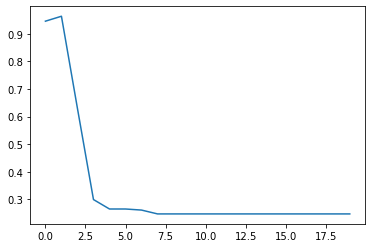

In [19]:
## TPR plot
import matplotlib.pyplot as plt
plt.plot(range(0,len(tpr_plot)),tpr_plot)

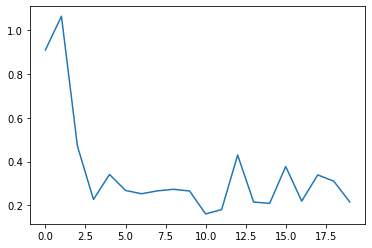

In [20]:
## Generator Plot
import matplotlib.pyplot as plt
plt.plot(range(0,len(tpr_plot)),gen_loss_plot)

# Experimentation
Experimentation Setup:

-> Initially we have taken 160 features, but got TPR of about 60%. This is because, the 160 features are not able to explain the complete variance in the dataset.So we took 350 features.

-> Optimal batch size is considered to be 128. In practice, for a GAN, lesser the batch size, better the performance. But less batch sizes takes hours to train, which makes it difficult to further analyze. So, batchs sizes of 64 and 128 are recommended and is a tradeoff with speed.

-> The optimal learning rate is set to 0.001. Learning rates of 0.05 and 0.01 tried but gave poor results because of such large step sizes in the initial stages. Lower rate like 0.0001 led to stable convergence but more TPR.

-> Uniform Noise of dimension 128 is used. More noise dimensions can help the generator come with good moves to fool the discriminator. Dimension size of 30 also worked but higher dimensions gives better results.

-> Dense dimensions of 256 has not enough capacity as the disciminator overthrown the generator leading to bad generations. Dimensions above 512 are used especially if the noise dimension is high.

The metric of Evaluation used is True Positive Rate (TPR).
It is the no of times the BBD is able to identify the malware correctly. We want this to be lower.